# Stock Price Prediction 


## Dataset

Giá chứng khoán FPT 

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../dataset/excel_fpt.csv')

In [3]:
data.tail()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
3485,FPT,20061219,27.4356,27.4356,27.4356,27.4356,137520
3486,FPT,20061218,26.1371,26.1371,26.1371,26.1372,215790
3487,FPT,20061215,24.8952,24.8952,24.8952,24.8952,265300
3488,FPT,20061214,23.7097,23.7097,23.7097,23.7097,280710
3489,FPT,20061213,22.5807,22.5807,22.5807,22.5807,83530


In [4]:
data.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,FPT,20201216,57.2,57.5,57.0,57.1,1995530
1,FPT,20201215,57.5,57.6,56.6,56.7,2666900
2,FPT,20201214,57.0,58.0,56.9,57.2,1443760
3,FPT,20201211,56.6,57.0,56.3,57.0,1750270
4,FPT,20201210,57.0,57.7,56.5,56.5,2112490


In [5]:
data.shape

(3490, 7)

- Giá tham chiếu: giá Close ngày hôm trước
- Giá Open: giá chốt lệnh lần đầu tiên trong ngày
- Giá High: giá khớp lệnh cao nhất trong ngày
- Giá Low: giá khớp lệnh thấp nhất trong ngày

In [6]:
columns = [i.replace('<', '').replace('>', '') for i in data.columns]

In [7]:
data = data.rename(columns = {data.columns[i]: columns[i] for i in range(len(data.columns))})

In [8]:
data.index = pd.to_datetime(data['DTYYYYMMDD'], format='%Y%m%d')
data.drop(columns=['DTYYYYMMDD', 'Ticker'], inplace=True)


In [9]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [10]:
df = data[['Close']]

## Metrics

Compute the **mean absolute percentage error (MAPE)** over all predictions

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}\left|\frac{actual_t - predicted_t}{actual_t}\right|$$

In [11]:
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
    error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]

    return np.mean(error) * 100


## Sktime

In [12]:
# !pip install sktime

In [13]:
from sktime.forecasting.all import *


### Train test split

In [14]:
def get_data_splits(df, train_size, test_size, validation_size=0):
    train_len = 0
    if isinstance(train_size, float) and train_size < 1:
        train_len = int(df.shape[0] * train_ratio)
    if isinstance(train_size, int) and train_size >= 1:
        train_len = train_size
        
    train_data = df.iloc[: train_len]
    
    test_len = 0
    if isinstance(test_size, float) and test_size < 1:
        test_len = int(df.shape[0] * test_ratio)
    if isinstance(test_size, int) and test_size >= 1:
        test_len = test_size
    test_data = df.iloc[-test_len:]
    
    if validation_size != 0:
        val_data = df.iloc[train_len:-test_len]
        return train_data, val_data, test_data
    else:
        return train_data, test_data

In [15]:
from sklearn.model_selection import train_test_split

In [125]:
target_col = 'Close'
df = df[[target_col]].sort_index()
# train_data, test_data = train_test_split(df, test_size=30, shuffle=False)

test_size = 30
validation_size = 150
train_size = len(df) - validation_size - test_size

train_data, validation_data, test_data = get_data_splits(df, train_size=train_size, validation_size=validation_size, test_size=test_size)
print('Train shape: ', train_data.shape)
print('Test shape: ', test_data.shape)


Train shape:  (3310, 1)
Test shape:  (30, 1)


In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

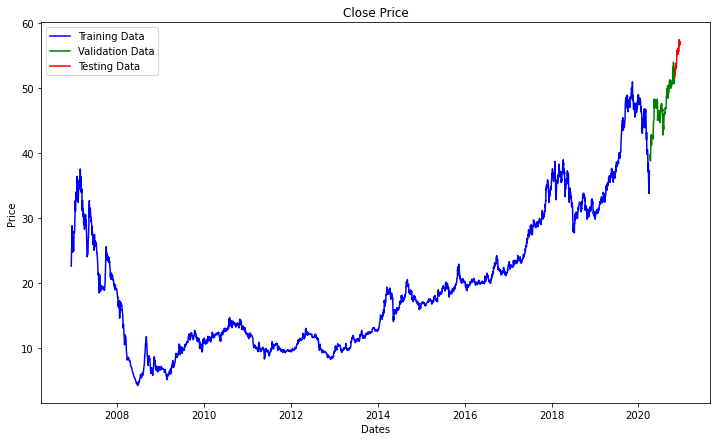

In [127]:
plt.figure(figsize=(12,7))
plt.title('Close Price')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data[target_col], 'blue', label='Training Data')
plt.plot(validation_data[target_col], 'green', label='Validation Data')

plt.plot(test_data[target_col], 'red', label='Testing Data')
plt.legend()


### Min Max scaling

In [128]:
import sklearn.preprocessing


In [223]:
use_feature_scaling = False

In [224]:
if use_feature_scaling:
    train_scaler = sklearn.preprocessing.MinMaxScaler()
    train_data = pd.DataFrame(train_scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
    validation_data = pd.DataFrame(train_scaler.fit_transform(validation_data), columns=validation_data.columns, index=validation_data.index)
    test_data = pd.DataFrame(train_scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

Relative forecasting horizon


One of the simplest ways is to define a np.array with the steps ahead that you want to predict relative to the end of the training series.

In [411]:
# fh = ForecastingHorizon(test_data[target_col].index, is_relative=True)
forecasting_horizon = len(validation_data)
fh = list(np.arange(len(validation_data[:forecasting_horizon])) + 1)


In [324]:
train_window = 1000

train_ts = train_data.iloc[-train_window:][target_col]
valid_ts = validation_data[target_col][:forecasting_horizon]

In [359]:
from pandas.plotting import autocorrelation_plot


In [361]:
from statsmodels.tsa.stattools import acf


In [374]:
np.argmin(np.abs(acf(train_ts, nlags=len(train_ts))))

295

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

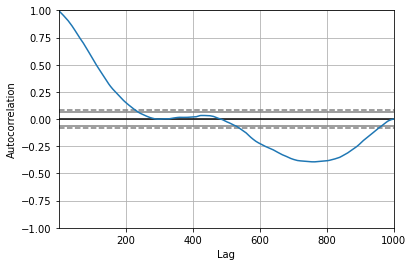

In [369]:
autocorrelation_plot(train_ts)

### Tuning

In [455]:
# forecaster_param_grid = {"sp": [1, 5, 20, 250, 365, 500]}

# regressor = GridSearchCV(ThetaForecaster(), param_grid=forecaster_param_grid)

# forecaster = ReducedRegressionForecaster(regressor=regressor, strategy="recursive")

# cv = SlidingWindowSplitter(initial_window=int(len(train_ts) * 0.5))

# gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
# gscv.fit(train_ts.reset_index(drop=True))
# y_pred = gscv.predict(fh)
from sklearn.model_selection import GridSearchCV

def find_best_sp(train_ts, valid_ts):
    def gridsearch(sps):
        best_param = (None, 100)

        for sp in sps:
            forecaster = ThetaForecaster(sp=sp)
            forecaster.fit(train_ts.reset_index(drop=True))
            y_pred = forecaster.predict(fh)
            y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
            mape = MAPE(valid_ts, y_pred)
            if mape < best_param[1]:
                best_param = (sp, mape)

    #         print(f'sp = {sp}, MAPE = {mape}')
#         print(best_param)
        return best_param

    sps = [1, 5, 20, 250, 300, 365, int(len(train_ts)/2)]
    new_sp = gridsearch(sps)[0]
#     print(new_sp)
    new_sps = range(max(new_sp - 25, 1), min(new_sp + 25, int(len(train_ts)/2)))
    best_param = gridsearch(new_sps)
    sp = best_param[0]
    print(best_param)
    return sp

sp = find_best_sp(train_ts, valid_ts)

(309, 11.91517415366637)


In [432]:
sp

309

### Theta Model

In [418]:
forecaster = ThetaForecaster(sp=sp)
forecaster.fit(train_ts.reset_index(drop=True))

ThetaForecaster(sp=309)

In [419]:
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)

y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])


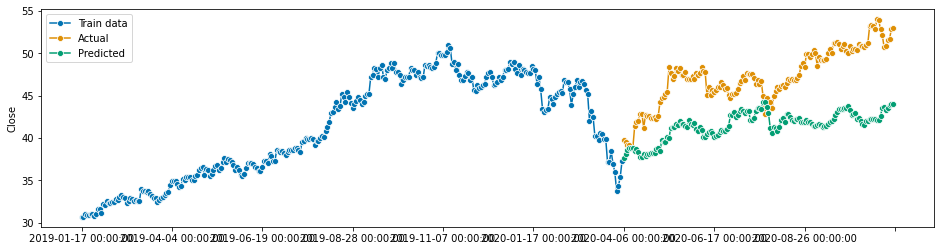

In [420]:
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])

# ax.fill_between(ax.get_lines()[-1].get_xdata(),
#                 pred_ints["lower"],
#                 pred_ints["upper"],
#                 alpha=0.2,
#                 color=ax.get_lines()[-1].get_c(),
#                 label=f"{1 - alpha}% prediction intervals",)
ax.legend()


In [421]:
MAPE(valid_ts, y_pred)

11.91517415366637

### AutoETS

In [422]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(sp=sp, trend='add', seasonal='multiplicative')
forecaster.fit(train_ts.reset_index(drop=True))
y_pred = forecaster.predict(fh)
y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])

/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [423]:
MAPE(valid_ts, y_pred)

15.283254692115673

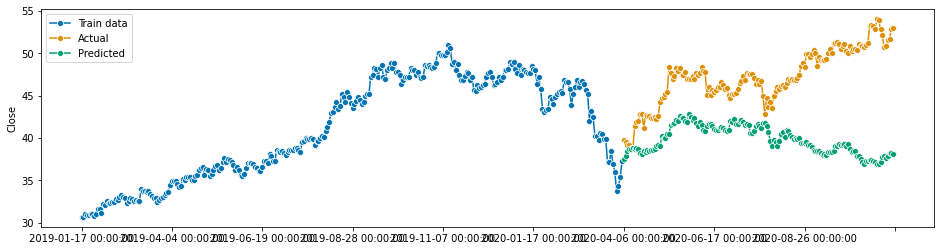

In [424]:
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

#### Auto

20.72854417819581


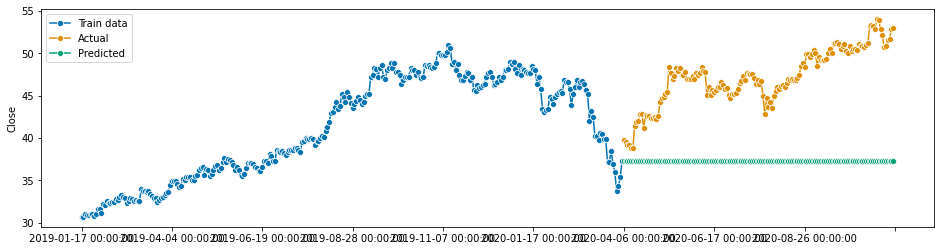

In [425]:
forecaster = AutoETS(auto=True)
forecaster.fit(train_ts.reset_index(drop=True))
y_pred = forecaster.predict(fh)
y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
print(MAPE(valid_ts, y_pred))
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

### Exponential Smoothing

/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


10.38181714488368


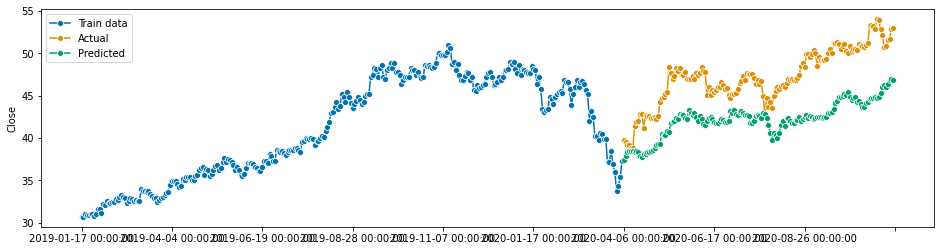

In [435]:
forecaster = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=sp)
forecaster.fit(train_ts.reset_index(drop=True))
y_pred = forecaster.predict(fh)
y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
print(MAPE(valid_ts, y_pred))
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

18.006951038842452


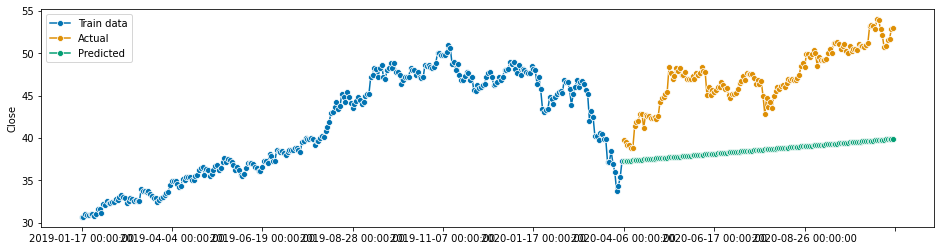

In [436]:
forecaster = ExponentialSmoothing(trend='add')
forecaster.fit(train_ts.reset_index(drop=True))
y_pred = forecaster.predict(fh)
y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
print(MAPE(valid_ts, y_pred))
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

### AutoARIMA

In [437]:
# forecaster = AutoARIMA(start_p=0, start_q=0, start_P=0, start_Q=0, seasonal=True, sp=sp, stepwise=True) 
# forecaster.fit(train_ts.reset_index(drop=True))
# y_pred = forecaster.predict(fh)
# y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
# print(MAPE(valid_ts, y_pred))
# fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
# plt.show()

20.671339070976856


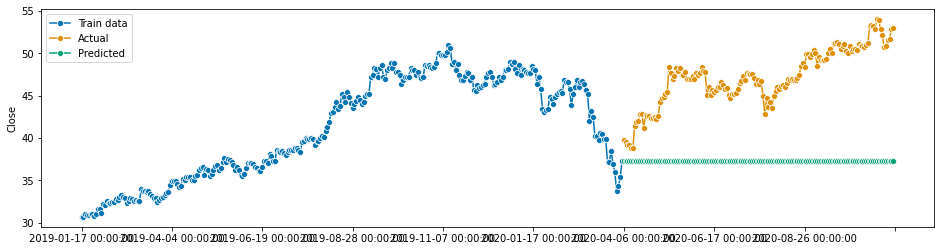

In [438]:
forecaster = AutoARIMA(start_p=0, start_q=0, start_P=0, start_Q=0, seasonal=True, sp=1, stepwise=True) 
forecaster.fit(train_ts.reset_index(drop=True))
y_pred = forecaster.predict(fh)
y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
print(MAPE(valid_ts, y_pred))
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

17.527294383386156


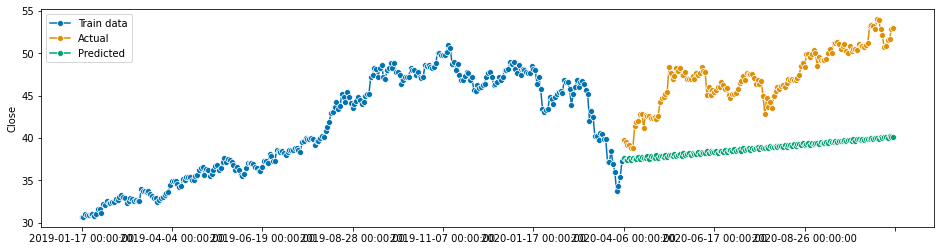

In [441]:
forecaster = AutoARIMA(suppress_warnings=True) 
forecaster.fit(train_ts.reset_index(drop=True))
y_pred = forecaster.predict(fh)
y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
print(MAPE(valid_ts, y_pred))
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

## Ensembling

In [442]:
forecaster = EnsembleForecaster([("theta", ThetaForecaster(sp=sp)),
                                 ("ets", AutoETS(sp=sp, trend='add', seasonal='multiplicative')),
                                 ("expsmoothing", ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=sp),),
                                 ("arima", AutoARIMA(suppress_warnings=True),),
                                 ], n_jobs=-1)


In [443]:
forecaster.fit(train_ts.reset_index(drop=True))


EnsembleForecaster(forecasters=[('theta', ThetaForecaster(sp=309)),
                                ('ets',
                                 AutoETS(seasonal='multiplicative', sp=309,
                                         trend='add')),
                                ('expsmoothing',
                                 ExponentialSmoothing(seasonal='multiplicative',
                                                      sp=309, trend='add')),
                                ('arima', AutoARIMA(suppress_warnings=True))],
                   n_jobs=-1)

In [444]:
MAPE(valid_ts, y_pred)

17.527294383386156

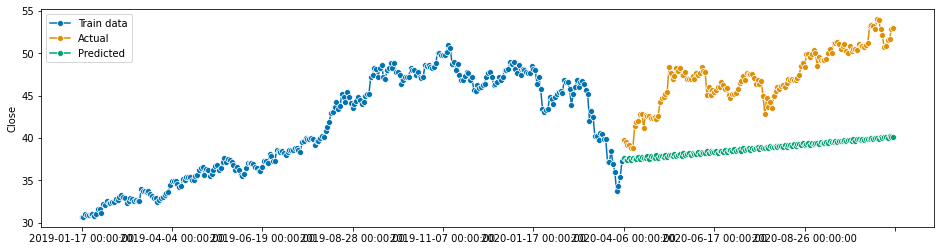

In [445]:
fig, ax = plot_series(train_ts[-2 * len(fh):], valid_ts, y_pred, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

In [470]:
# fh = ForecastingHorizon(test_data[target_col].index, is_relative=True)
forecasting_horizon = len(validation_data)
fh = list(np.arange(range(forecasting_horizon)) + 1)


In [471]:
train_window = 1000

train_ts = train_data.iloc[-train_window:][target_col]
valid_ts = validation_data[target_col][:forecasting_horizon]

In [472]:
sp = find_best_sp(train_ts, valid_ts)
train_ts = pd.concat([train_ts, valid_ts])

(309, 11.91517415366637)


In [473]:
models = [("theta", ThetaForecaster(sp=sp)),
          ("ets", AutoETS(sp=sp, trend='add', seasonal='multiplicative')),
          ("expsmoothing", ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=sp)),
          ("arima", AutoARIMA(suppress_warnings=True))]

In [474]:
%%time

ensembled_model = {}
for model in models:
    model_name = model[0]
    model_instance = model[1]
    model_instance.fit(train_ts.reset_index(drop=True))
    y_pred = forecaster.predict(fh)
    y_pred = pd.Series(y_pred.values, index=valid_ts.index[:len(fh)])
    ensembled_model[model_name] = {}
    ensembled_model[model_name]['weight'] = 100 - MAPE(valid_ts, y_pred) 
    ensembled_model[model_name]['model'] = model_instance

/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


CPU times: user 1min 8s, sys: 1.85 s, total: 1min 9s
Wall time: 1min 6s


In [475]:
ensembled_model

{'theta': {'weight': 86.23470355685045, 'model': ThetaForecaster(sp=309)},
 'ets': {'weight': 86.23470355685045,
  'model': AutoETS(seasonal='multiplicative', sp=309, trend='add')},
 'expsmoothing': {'weight': 86.23470355685045,
  'model': ExponentialSmoothing(seasonal='multiplicative', sp=309, trend='add')},
 'arima': {'weight': 86.23470355685045,
  'model': AutoARIMA(suppress_warnings=True)}}

In [476]:
forecasting_horizon = 7
fh = list(np.arange(range(forecasting_horizon)) + 1)


In [489]:
def get_ensembled_prediction(ensembled_model, fh, test_ts):
    ensembled_prediction = []
    total_weight = 0
    for model_name, model in ensembled_model.items():
#         print(model_name)
        predictions = model['model'].predict(fh)
        model_weight = model['weight']
        total_weight += model_weight
        ensembled_prediction.append(predictions * model_weight)
    ensembled_prediction = np.array(ensembled_prediction).sum(axis=0) / total_weight 
    ensembled_prediction = pd.Series(ensembled_prediction, index=test_ts.index[:len(fh)])
    return ensembled_prediction

In [491]:
result = get_ensembled_prediction(ensembled_model, fh, test_ts)


theta
ets
expsmoothing
arima


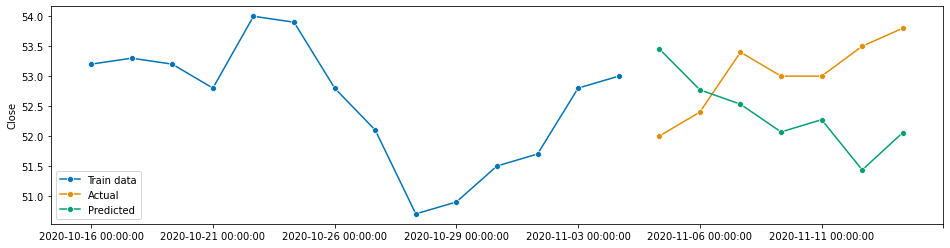

In [492]:
fig, ax = plot_series(train_ts[-2 * len(fh):], test_ts, result, labels=['Train data', 'Actual', 'Predicted'])
plt.show()

In [493]:
MAPE(test_ts, result)

2.19463834549726